Mandarin Tone Recognition Part 1
===========
This notebook demonstrates a Mandarin tone recognition algorithm that takes audio recordings of chinese words from wiktionary. The resulting classifier should be able to recognise the spoken tone from a user audio input.

A description of mandarin tones is available here: https://en.wikipedia.org/wiki/Standard_Chinese_phonology#Tones

## 1. Wiktionary Parser

The wiktionary parser library can download pronunciation audio files and text files for a specified chinese character

In [1]:
from wiktionaryparser import WiktionaryParser
import requests
import re

ModuleNotFoundError: No module named 'wiktionaryparser'

In [2]:
parser = WiktionaryParser()
word = parser.fetch('我', 'chinese')
print(word[0]['pronunciations']['text'])

['Mandarin(Standard)(Pinyin): wǒ, ě (wo, e)(Zhuyin): ㄨㄛˇ, ㄜˇ(Chengdu, SP): ngo(Dungan, Cyrillic): вә (və, II)', 'Cantonese(Guangzhou, Jyutping): ngo(Taishan, Wiktionary): ngoi, ngo, ngoi', 'Gan (Wiktionary): ngo', 'Hakka(Sixian, PFS): ngô(Meixian, Guangdong): ngo', 'Jin (Wiktionary): ghe', 'Min Bei (KCR): uòi', 'Min Dong (BUC): nguāi / ngō̤', "Min Nan(Hokkien, POJ): góa / óa / ngó͘(Teochew, Peng'im): ua / ngo", 'Wu (Wiktionary): ngu (T3); hhu (T3)', 'Xiang (Wiktionary): ngo', 'Mandarin', '(Standard Chinese, vernacular, standard)', 'Pinyin: wǒ', 'Zhuyin: ㄨㄛˇ', 'Wade–Giles: wo', 'Gwoyeu Romatzyh: wuuo', 'Tongyong Pinyin: wǒ', 'IPA : /wɔ²¹⁴/', '(Standard Chinese, literary, rare variant)', 'Pinyin: ě', 'Zhuyin: ㄜˇ', 'Wade–Giles: o', 'Gwoyeu Romatzyh: ee', 'Tongyong Pinyin: ě', 'IPA : /ˀɤ²¹⁴/', '(Chengdu)', 'Sichuanese Pinyin: ngo', 'Scuanxua Ladinxua Xin Wenz: ngo', 'IPA : /ŋo⁵³/', '(Dungan)(Note: Dungan pronunciation is currently experimental and may be inaccurate.)', 'Cyrillic: вә (və, I

For this project, the first mandarin pronunciation only is required

In [3]:
print(word[0]['pronunciations']['text'][0])

Mandarin(Standard)(Pinyin): wǒ, ě (wo, e)(Zhuyin): ㄨㄛˇ, ㄜˇ(Chengdu, SP): ngo(Dungan, Cyrillic): вә (və, II)


The pinyin wǒ indicates that the character 我 is pronounced using the third tone

¯ first tone

´ second tone

ˇ third tone

\` fourth tone

This pinyin can be obtained as follows:

In [4]:
pinyin = word[0]['pronunciations']['text'][0].split(":")[1].split()[0]
print(pinyin)

wǒ,


We can extract the tone number using regular expression

In [5]:
def get_tone(sylable):
    if re.search("[āēīōūǖĀĒĪŌŪǕ]", sylable):
        tone = 1
    elif re.search("[áéíóúǘÁÉÍÓÚǗ]", sylable):
        tone = 2
    elif re.search("[ǎěǐǒǔǚǍĚǏǑǓǙ]", sylable):
        tone = 3
    elif re.search("[àèìòùǜÀÈÌÒÙǛ]", sylable):
        tone = 4
    elif re.search("[aeiouüAEIOUÜ]", sylable):
        tone = 5
    else:
        tone = None
        print("Tone error: ", sylable)
    return tone

In [6]:
get_tone(pinyin)

3

The wiktionary parser also provides links to pronunciation audio files if available (availability is limited). The first of these links is to the standard mandarin pronunciation.

In [7]:
word[0]['pronunciations']['audio']

['//upload.wikimedia.org/wikipedia/commons/4/42/Zh-w%C7%92.ogg',
 '//upload.wikimedia.org/wikipedia/commons/transcoded/7/70/Cdo-fzho%2C_%E6%88%91.ogg/Cdo-fzho%2C_%E6%88%91.ogg.mp3',
 '//upload.wikimedia.org/wikipedia/commons/0/02/Taiwanese-The_Consonant_g.ogg']

We can download the audio file using the requests module

In [8]:
url = 'https:' + word[0]['pronunciations']['audio'][0]
r = requests.get(url, allow_redirects=True)
with open(r'pronunciation.ogg', 'wb') as file:
    file.write(r.content)

These steps are combined into the following function

In [9]:
def get_pronuncitation(character, verbose=False):
    """
    Returns the standard pronunciation tone for the provided character
    If no audio files are available for the character return False
    Also saves the related audio file as ...\pronunciation.ogg
    """
    try:
        word = parser.fetch(character, 'chinese')
        if len(word[0]['pronunciations']['audio']) > 0:
            if verbose:
                print(word[0]['pronunciations']['text'][0])
                print("tone: ", get_tone(word[0]['pronunciations']['text'][0].split(":")[1].split()[0]))
            tone = get_tone(word[0]['pronunciations']['text'][0].split(":")[1].split()[0])
            url = 'https:' + word[0]['pronunciations']['audio'][0]
            r = requests.get(url, allow_redirects=True)
            with open(r'pronunciation.ogg', 'wb') as file:
                file.write(r.content)
            return tone
        else:
            if verbose:
                print("No audio file available for this hanzi")
            return False
    except:
        return False

In [10]:
get_pronuncitation("我")

3

## 2. Audio File Structure

In this section we use the signal spectogram to view differences between tones

In [11]:
from pydub import AudioSegment
from pydub import silence
import numpy as np
from scipy import signal
from scipy.io import wavfile
from scipy.stats import mode
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

The pydub module can be used to play the audio file, convert it to .wav format, and perform various other useful functions

In [12]:
AudioSegment.from_ogg(r'pronunciation.ogg')

In [13]:
sound = AudioSegment.from_ogg(r'pronunciation.ogg')
sound = silence.split_on_silence(sound)[0]
sound.export(r'pronunciation.wav', format="wav")
sound

In [14]:
fs, data = wavfile.read(r'pronunciation.wav')

Use scipy.signal.spectrogram to plot a spectogram of the audio file

C:\Users\Chris\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:154: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


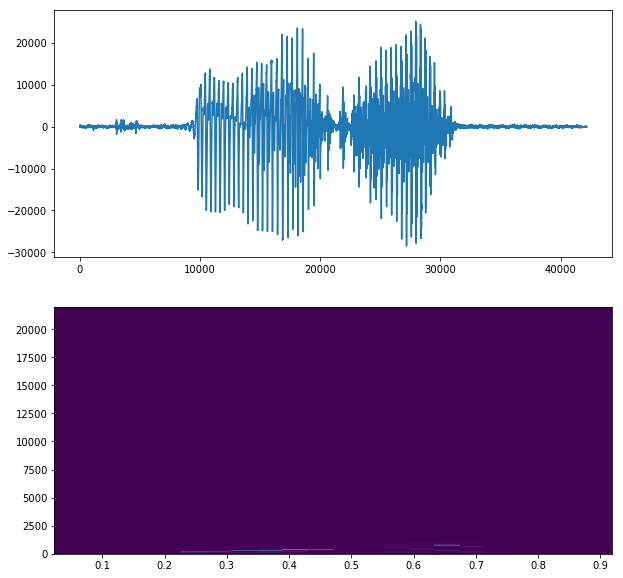

In [15]:
fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(data)
f, t, Sxx = signal.spectrogram(data, fs, nperseg=1024*2, nfft=1024*4)

ax[1].pcolormesh(t, f, Sxx)

Frequencies with relevant data are all appearing at the bottom of the figure. We can reduce the frequency to a maximum of 500 to view the relevant data

(46,)


C:\Users\Chris\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:154: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


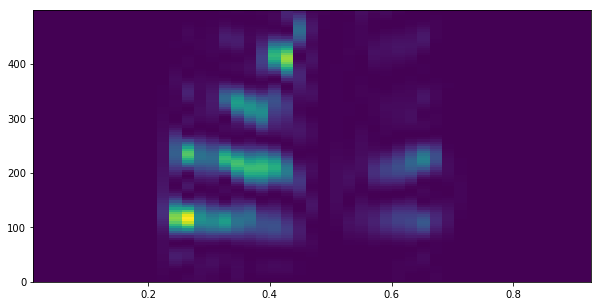

In [16]:
fig = plt.figure(figsize=(10,5))

f, t, Sxx = signal.spectrogram(data, fs, nperseg=1024, nfft=1024*10)

#Trim the frequency domain
bound = len([freq for freq in f if freq < 500])
f = f[:bound]
Sxx = Sxx[:bound]
print(t.shape)
plt.pcolormesh(t, f, Sxx)

The third tone structure is clear from this figure. However we can also trim the time domain to remove what appears to be silence before and after the sound.

C:\Users\Chris\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:154: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


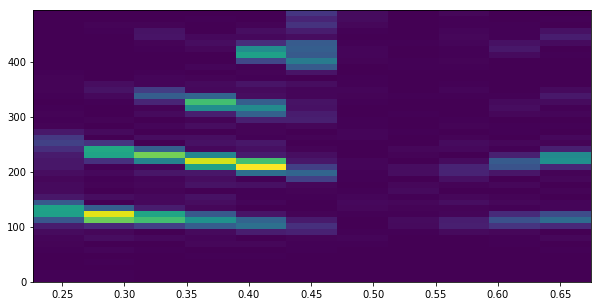

In [17]:
fig = plt.figure(figsize=(10,5))

f, t, Sxx = signal.spectrogram(data, fs, nperseg=1024*2, nfft=1024*4)

#Trim the frequency domain
bound = len([freq for freq in f if freq < 500])
f = f[:bound]
Sxx = Sxx[:bound]

#Trim leading time domain
sound_present = [np.max(column) > np.max(Sxx)*0.05 for column in np.transpose(Sxx)]
start_index = sound_present.index(True)
end_index = len(sound_present) - sound_present[::-1].index(True)
t = t[start_index:end_index]
Sxx = np.transpose(np.transpose(Sxx)[start_index:end_index])

plt.pcolormesh(t, f, Sxx)

A vertical cross section of the figure shows the frequency structure at a specific time point. The peaks at ~129 and ~257 correspond to the two lighter colored sections on the far left of the previous figure.

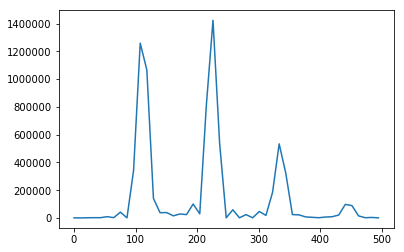

Signal peaks were found at the following frequencies: [107.421875, 118.1640625, 225.5859375, 236.328125, 343.75, 354.4921875, 451.171875]


C:\Users\Chris\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [18]:
time=2
spectrum = np.transpose(Sxx)[time]
plt.plot(f, spectrum)
plt.show()
peaks = [f[t] for t in signal.find_peaks_cwt(np.transpose(Sxx)[time], np.arange(1,10))]
print("Signal peaks were found at the following frequencies:", peaks)

To map the tone lines, we first determine the peaks at each time point. From now on we will use the index of the frequency domain f for simplicity (e.g., f[12] = 128.90625)

In [19]:
spectrum_peaks = []
search_window = 3
for spectrum in np.transpose(Sxx):
    peaks = []
    for peak in signal.find_peaks_cwt(spectrum, np.arange(1,10)):
        peak = peak - search_window + np.argmax(spectrum[max(peak - search_window, 0):min(peak + search_window, len(spectrum))])
        if spectrum[peak]/np.max(Sxx) > 0.05:
            peaks.append(peak)
    
    # find_peaks_cwt provides the widths argument; 
    # if no peaks are found for widths=np.arange(1,10) try widths=np.arange(5,10)
    if len(peaks) == 0:
            for peak in signal.find_peaks_cwt(spectrum, np.arange(5,10)):
                peak = peak - search_window + np.argmax(spectrum[max(peak - search_window, 0):min(peak + search_window, len(spectrum))])
                if spectrum[peak]/np.max(Sxx) > 0.05:
                    peaks.append(peak)
    if len(peaks) > 0:
        peaks = sorted(list(set(peaks)))
        spectrum_peaks.append(peaks)
print(spectrum_peaks)

[[12, 23], [11, 22], [10, 21, 31, 41], [10, 20, 30], [9, 19, 38], [9, 18, 27, 37], [9, 18], [10, 19, 20, 39], [10, 20, 41], [10, 20]]


C:\Users\Chris\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Finally, we must use the extracted list of peaks to obtain a list of tone lines

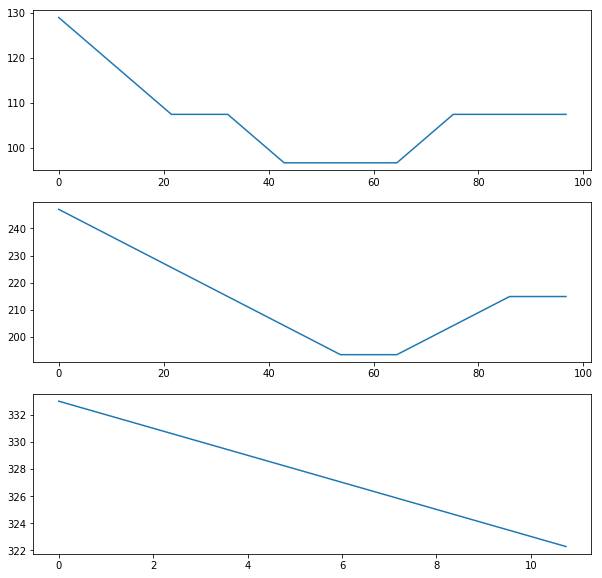

In [20]:
def contains_sublist(lst, sublst):
    n = len(sublst)
    return any((sublst == lst[i:i+n]) for i in range(len(lst)-n+1))

max_lines = max([len(peaks) for peaks in spectrum_peaks])
start_spectrum_indices = []
for i in range(max_lines):
    start_spectrum_indices.append([len(peaks) > i for peaks in spectrum_peaks].index(True))

lines = []
window = 3

for i in range(max_lines):
    line=[]
    last_found = spectrum_peaks[start_spectrum_indices[i]][0]
    line.append(spectrum_peaks[start_spectrum_indices[i]].pop(0))
    for j in range(start_spectrum_indices[i] + 1, len(spectrum_peaks)-start_spectrum_indices[i]):
        if any([np.abs(peak-last_found) < window for peak in spectrum_peaks[j]]):
            next_item = spectrum_peaks[j].pop(spectrum_peaks[j].index([peak for peak in spectrum_peaks[j] if np.abs(peak-last_found) < window][0]))
            line.append(next_item)
            last_found = next_item
        else:
            line.append(None)
    
    while line[-1] == None:
        line.pop()
    
    if any([len([item for item in i if item])==2 for i in itertools.combinations(line,2) if contains_sublist(line, list(i))]):
        lines.append(line)

fig, ax = plt.subplots(len(lines),figsize=(10,10))
for i, line in enumerate(lines):
    ax[i].plot(f[:len(line)], [f[index] if index else None for index in line])

The above steps are combined into the following functions

In [21]:
def get_spectrum_peaks(path):
    fs, data = wavfile.read(path)
    if len(data.shape) > 1:
        data = np.transpose(data)[0]
    f, t, Sxx = signal.spectrogram(data, fs, nperseg=1024*2, nfft=1024*4)
    
    #Trim the frequency domain
    bound = len([freq for freq in f if freq < 500])
    f = f[:bound]
    Sxx = Sxx[:bound]
    
    #Trim leading time domain
    sound_present = [np.max(column) > np.max(Sxx)*0.05 for column in np.transpose(Sxx)]
    start_index = sound_present.index(True)
    end_index = len(sound_present) - sound_present[::-1].index(True)
    t = t[start_index:end_index]
    Sxx = np.transpose(np.transpose(Sxx)[start_index:end_index])
    
    spectrum_peaks = []
    search_window = 3
    for spectrum in np.transpose(Sxx):
        peaks = []
        for peak in signal.find_peaks_cwt(spectrum, np.arange(1,10)):
            peak = peak - search_window + np.argmax(spectrum[max(peak - search_window, 0):min(peak + search_window, len(spectrum))])
            if spectrum[peak]/np.max(Sxx) > 0.05:
                peaks.append(peak)
        if len(peaks) == 0:
                for peak in signal.find_peaks_cwt(spectrum, np.arange(5,10)):
                    peak = peak - search_window + np.argmax(spectrum[max(peak - search_window, 0):min(peak + search_window, len(spectrum))])
                    if spectrum[peak]/np.max(Sxx) > 0.05:
                        peaks.append(peak)
        if len(peaks) > 0:
            peaks = sorted(list(set(peaks)))
            spectrum_peaks.append(peaks)
    
    return spectrum_peaks, f, t, Sxx

In [22]:
def get_tone_lines(spectrum_peaks, window=3):
    max_lines = max([len(peaks) for peaks in spectrum_peaks])
    start_spectrum_indices = []
    for i in range(max_lines):
        start_spectrum_indices.append([len(peaks) > i for peaks in spectrum_peaks].index(True))

    lines = []
    
    def contains_sublist(lst, sublst):
        n = len(sublst)
        return any((sublst == lst[i:i+n]) for i in range(len(lst)-n+1))
    
    for i in range(max_lines):
        line=[]
        last_found = spectrum_peaks[start_spectrum_indices[i]][0]
        line.append(spectrum_peaks[start_spectrum_indices[i]].pop(0))
        for j in range(start_spectrum_indices[i] + 1, len(spectrum_peaks)-start_spectrum_indices[i]):
            #line, last_found = update_line(spectrum_peaks[j], last_found, line, window=3)
            if any([np.abs(peak-last_found) < window for peak in spectrum_peaks[j]]):
                next_item = spectrum_peaks[j].pop(spectrum_peaks[j].index([peak for peak in spectrum_peaks[j] if np.abs(peak-last_found) < window][0]))
                line.append(next_item)
                last_found = next_item
            else:
                line.append(None)
    
        while line[-1] == None:
            line.pop()
            
        if any([len([item for item in i if item])==2 for i in itertools.combinations(line,2) if contains_sublist(line, list(i))]):
            lines.append(line)
            
    return lines

### A summary of the project so far

C:\Users\Chris\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:154: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Chris\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


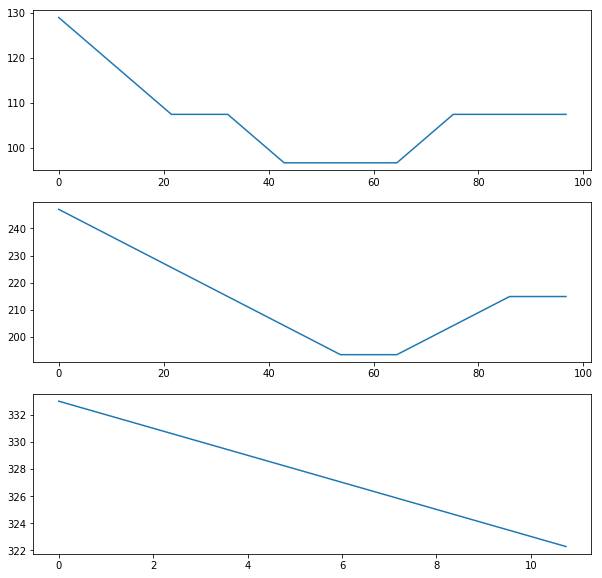

In [23]:
character = '我'

pronunciation = get_pronuncitation(character)

if pronunciation:
    sound = AudioSegment.from_ogg(r'pronunciation.ogg')
    silences = silence.split_on_silence(sound)
    if len(silences) == 1:
        sound = silences[0]
    sound.export(r'pronunciation.wav', format="wav")

    spectrum_peaks, f, t, Sxx = get_spectrum_peaks(r'pronunciation.wav')
    
    lines = get_tone_lines(spectrum_peaks, window=3)
    
    if len(lines) == 0:
        spectrum_peaks, f, t, Sxx = get_spectrum_peaks(r'pronunciation.wav')
        lines = get_tone_lines(spectrum_peaks, window=6)
        
fig, ax = plt.subplots(len(lines),figsize=(10,10))
for i, line in enumerate(lines):
    ax[i].plot(f[:len(line)], [f[index] if index else None for index in line])

## 3. Feature Extraction

Having extracted tone lines for the character pronunciation, we use the lines to determine various features that may be useful for training the classifier

In [24]:
from scipy.interpolate import interp1d
from scipy.misc import derivative
from collections import Counter

In [25]:
turning_points = []
max_min_difs = []
avg_grads = []

if len(lines) > 1:
    for i in range(len(lines)):
        print("Tone line", i)
        f2 = interp1d(np.linspace(0, len(lines[i])-1, len(lines[i])), lines[i], kind='linear')

        diff = [round(derivative(f2, x, dx=1e-6)) for x in np.linspace(0.001, len(lines[i])-1.001, 50) if round(derivative(f2, x, dx=1e-6)) != 0]
        turning_point = Counter([(np.sign(diff[i]) == -1 * np.sign(diff[i+1])) and diff[i] != 0 for i in range(len(diff)-1)])[True]
        turning_points.append(turning_point)
        print('Number of turning points: ', turning_point)
        max_min_dif = max([point for point in lines[i] if point])-min([point for point in lines[i] if point])
        max_min_difs.append(max_min_dif)
        print('Max-min difference: ', max_min_dif)
        avg_grad= np.mean([point for point in [round(derivative(f2, x, dx=1e-6)) for x in np.linspace(0.001, len(lines[i])-1.001, 50)] if not np.isnan(point)])
        avg_grads.append(avg_grad)
        print('Average gradient: ', avg_grad)
        print('...')
elif len(lines) == 1:
    f2 = interp1d(np.linspace(0, len(lines[0])-1, len(lines[0])), lines[0], kind='linear')

    diff = [round(derivative(f2, x, dx=1e-6)) for x in np.linspace(0.001, len(lines[0])-1.001, 50) if round(derivative(f2, x, dx=1e-6)) != 0]
    turning_points = Counter([(np.sign(diff[i]) == -1 * np.sign(diff[i+1])) and diff[i] != 0 for i in range(len(diff)-1)])[True]
    print('Number of turning points: ', turning_points)
    print('Max-min difference: ', max([point for point in lines[0] if point])-min([point for point in lines[0] if point]))
    print('Average gradient: ', np.mean([point for point in [round(derivative(f2, x, dx=1e-6)) for x in np.linspace(0.001, len(lines[0])-1.001, 50)] if not np.isnan(point)]))

Tone line 0
Number of turning points:  1
Max-min difference:  3
Average gradient:  -0.2
...
Tone line 1
Number of turning points:  1
Max-min difference:  5
Average gradient:  -0.34
...
Tone line 2
Number of turning points:  0
Max-min difference:  1
Average gradient:  -1.0
...


We can combine the statistics for the multiple tone lines. The following statistics are suggested:

* mean gradient, 
* primary tone gradient, 
* mean max-min difference, 
* maximum max-min difference, 
* primary tone max-min difference, 
* mean number of turning points, 
* mode of turning points, 
* primary tone number of turning points.

## 4. Data Collection

Build a dataset of these statistics for the audio files available on wiktionary. A list of the 1500 most common mandarin characters was obtained from https://sensiblechinese.com/common-chinese-characters/

The list of characters are extracted from the text file, and looped over to build a dataframe with each row representing one character.

In [26]:
import pandas as pd

In [27]:
with open(r'chars.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
    
chars = [line.split('\t')[1] for line in lines]

In [28]:
from tqdm import tqdm_notebook

Looping through all characters may take several minutes

In [29]:
df = pd.DataFrame({"hanzi": [], 
                   "tone": [], 
                   "time": [], 
                   "frequency": [], 
                   "Sxx": [], 
                   "lines": [], 
                   "turning_points": [], 
                   "max_min_difs": [],
                   "avg_grads": []})

for char in tqdm_notebook(chars):
    tone = get_pronuncitation(char,verbose=False)
    if tone:
        try:
            sound = AudioSegment.from_ogg(r'pronunciation.ogg')
        except Exception as e: 
            print(e)
            pass
        silences = silence.split_on_silence(sound)
        if len(silences) == 1:
            sound = silences[0]
        sound.export(r'pronunciation.wav', format="wav")

        spectrum_peaks, f, t, Sxx = get_spectrum_peaks(r'pronunciation.wav')

        lines = get_tone_lines(spectrum_peaks, window=3)
        if len(lines) == 0:
            spectrum_peaks, f, t, Sxx = get_spectrum_peaks(r'pronunciation.wav')
            lines = get_tone_lines(spectrum_peaks, window=6)

        turning_points = []
        max_min_difs = []
        avg_grads = []

        if len(lines) > 0:
            for i in range(len(lines)):
                f2 = interp1d(np.linspace(0, len(lines[i])-1, len(lines[i])), lines[i], kind='linear')

                diff = [round(derivative(f2, x, dx=1e-6)) for x in np.linspace(0.001, len(lines[i])-1.001, 50) if round(derivative(f2, x, dx=1e-6)) != 0]
                turning_point = Counter([(np.sign(diff[i]) == -1 * np.sign(diff[i+1])) and diff[i] != 0 for i in range(len(diff)-1)])[True]
                turning_points.append(turning_point)
                max_min_dif = max([point for point in lines[i] if point])-min([point for point in lines[i] if point])
                max_min_difs.append(max_min_dif)
                avg_grad = np.mean([point for point in [round(derivative(f2, x, dx=1e-6)) for x in np.linspace(0.001, len(lines[i])-1.001, 50)] if not np.isnan(point)])
                avg_grads.append(avg_grad)

        df = df.append(pd.DataFrame({"hanzi": [char], 
                                     "tone": [tone], 
                                     "time": [t], 
                                     "frequency": [f], 
                                     "Sxx": [Sxx], 
                                     "lines": [lines],
                                     "turning_points": [turning_points], 
                                     "max_min_difs": [max_min_difs],
                                     "avg_grads": [avg_grads]}), ignore_index=True)
df.head()

C:\Users\Chris\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:154: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Chris\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: invalid value encountered in sign


Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

b'ffmpeg version N-94150-g231d0c819f Copyright (c) 2000-2019 the FFmpeg developers\r\n  built with gcc 9.1.1 (GCC) 20190621\r\n  configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libmfx --enable-amf --enable-ffnvcodec --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec -

,Sxx,avg_grads,frequency,hanzi,lines,max_min_difs,time,tone,turning_points
0,"[[7728.451, 7436.4727, 997.15375, 0.8600962, 9...","[-0.2, -0.34, -1.0]","[0.0, 10.7421875, 21.484375, 32.2265625, 42.96...",我,"[[12, 11, 10, 10, 9, 9, 9, 10, 10, 10], [23, 2...","[3, 5, 1]","[0.22690909090909092, 0.2676363636363636, 0.30...",3.0,"[1, 1, 0]"
1,"[[3869.849, 9412.11, 1903.0175, 1944.4612, 406...",[-1.5],"[0.0, 10.7421875, 21.484375, 32.2265625, 42.96...",的,"[[20, 19, 17]]",[3],"[0.22690909090909092, 0.2676363636363636, 0.30...",4.0,[0]
2,"[[624.7778, 56.12505, 47187.285, 3510.1235, 12...","[0.2647058823529412, 0.1]","[0.0, 10.7421875, 21.484375, 32.2265625, 42.96...",你,"[[12, 12, 12, 12, 11, 11, None, None, None, 10...","[3, 5]","[0.22690909090909092, 0.2676363636363636, 0.30...",3.0,"[0, 4]"
3,"[[2161.7483, 152.5279, 2452.7324, 2910.2466], ...","[-1.0, 2.0]","[0.0, 10.7421875, 21.484375, 32.2265625, 42.96...",是,"[[20, 19], [39, 41]]","[1, 2]","[0.3490909090909091, 0.38981818181818184, 0.43...",4.0,"[0, 0]"
4,"[[4128.331, 1.1818495, 2070.6196, 5618.5806], ...",[0.0],"[0.0, 10.7421875, 21.484375, 32.2265625, 42.96...",了,"[[11, 11]]",[0],"[0.22690909090909092, 0.2676363636363636, 0.30...",5.0,[0]


Check whether lines were not properly obtained for each character; drop rows that did not obtain lines.

In [36]:
df = df.drop(df[df.max_min_difs.apply(lambda x: len(x)) == 0].index.tolist())
df[df.max_min_difs.apply(lambda x: len(x)) == 0]

,Sxx,avg_grads,frequency,hanzi,lines,max_min_difs,time,tone,turning_points,mean_grad


Calculate the features for each character

In [37]:
df["mean_grad"] = df.avg_grads.apply(lambda x: np.mean(x))
df["prime_tone_grad"] = df.avg_grads.apply(lambda x: x[0])
df["mean_dif"] = df.max_min_difs.apply(lambda x: np.mean(x))
df["max_dif"] = df.max_min_difs.apply(lambda x: np.max(x))
df["prime_tone_dif"] = df.max_min_difs.apply(lambda x: x[0])
df["mean_tp"] = df.turning_points.apply(lambda x: np.mean(x))
df["mode_tp"] = df.turning_points.apply(lambda x: mode(x).mode[0])
df["prime_tone_tp"] = df.turning_points.apply(lambda x: x[0])

## 5. Classifier training

In this section we use the extracted features to train a random forrest classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Define the training and testing sets

In [39]:
X = df.loc[:, "mean_grad":"prime_tone_tp"].values
y = df.tone.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Use KFold cross validation to determine the optimum parameter settings for the random forest classifier

In [40]:
kf = KFold(n_splits=15)

clf = RandomForestClassifier(n_estimators=200, max_depth=8, max_features=4)
scores = cross_val_score(clf, X_train, y_train, cv=kf)

np.mean(scores)

0.7440821256038649

Train the classifier using these settings and print the accuracy for the test set.

In [41]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.7272727272727273

## 6. User Input Classification

With the trained classifier, we can record a character pronunciation and use the classifier to determine the tone. The recorded sound file is processed as above and the classifier features are extracted.

In [42]:
import sounddevice as sd
from scipy.io.wavfile import write

In [49]:
def predict_tone():
    fs = 44000
    seconds = 3 
    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
    sd.wait()
    write(r'rec.wav', fs, myrecording)
    
    spectrum_peaks, f, t, Sxx = get_spectrum_peaks(r'rec.wav')
    
    lines = get_tone_lines(spectrum_peaks, window=3)
    if len(lines) == 0:
        spectrum_peaks, f, t, Sxx = get_spectrum_peaks(r'rec.wav')
        lines = get_tone_lines(spectrum_peaks, window=6)

    turning_points = []
    max_min_difs = []
    avg_grads = []

    if len(lines) > 0:
        for i in range(len(lines)):
            f2 = interp1d(np.linspace(0, len(lines[i])-1, len(lines[i])), lines[i], kind='linear')

            diff = [round(derivative(f2, x, dx=1e-6)) for x in np.linspace(0.001, len(lines[i])-1.001, 50) if round(derivative(f2, x, dx=1e-6)) != 0]
            turning_point = Counter([(np.sign(diff[i]) == -1 * np.sign(diff[i+1])) and diff[i] != 0 for i in range(len(diff)-1)])[True]
            turning_points.append(turning_point)
            max_min_dif = max([point for point in lines[i] if point])-min([point for point in lines[i] if point])
            max_min_difs.append(max_min_dif)
            avg_grad = np.mean([point for point in [round(derivative(f2, x, dx=1e-6)) for x in np.linspace(0.001, len(lines[i])-1.001, 50)] if not np.isnan(point)])
            avg_grads.append(avg_grad)
            
    x = [np.mean(avg_grads), 
         avg_grads[0], 
         np.mean(max_min_difs), 
         np.max(max_min_difs), 
         max_min_difs[0], 
         np.mean(turning_points), 
         mode(turning_points).mode[0],
         turning_points[0]]
    
    return clf.predict(x)[0]

Run the following cell to record a single character. The classifier will return the estimated tone.

In [50]:
predict_tone()

C:\Users\Chris\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:154: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Chris\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if 

1.0

## 7. Next Steps

The are several clear defficiencies with the above method

1. Insufficient training data. The number of single character pronunciation recordings available on wikitionary is limitted to approximately 450. Additional sources of pronunciation audio files should be added.
2. The obtained training data were mostly recorded using a male voice. Female recordings should be added to the training data. Alternatively, separate models could be trained for male and female voices.
3. Single character pronunciation training may be most benificial for absolute beginners. The method should be extended to two character words and ultimately full sentences.

An alternative approach

* Apply pattern recognition techniques from computer vission such as convolutional neural networks to the spectrograph images for tone pronunciations. This method may be more suitable for multi-character words and sentences.